Para empezar importamos todo lo necesario

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# version original sin modificar extraida de
# lucy's blog (https://lucyliu-ucsb.github.io/posts/Backpropagation-of-a-vanilla-RNN/)
class vanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate):
        # hyperparameters
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        
        # initialize model parameters
        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))
        
        # memory vars for adagrad
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)
    
    def forward_pass(self, inputs, targets, hprev):
        """
        inputs -- list of integers (tokenizer: char to int)
        targets -- list of integers (tokenizer: char to int)
        hprev -- the initial hidden state
        """
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0
    
        for t in range(len(inputs)):
            
            # one hot encoder of a char
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss = loss - np.log(p[t][targets[t], 0])
            
        return loss, x, h, p

    def backpropagation(self, x, h, p, targets):
        
        dWxh, dWhy, dWhh = np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.Whh)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])
        
        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] =  dy[targets[t]] - 1
            dWhy = dWhy + dy @ h[t].T
            dby = dby + dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh = dbh + dhraw
            dWxh = dWxh + dhraw @ x[t].T
            dWhh = dWhh + dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw
        for dpara in [dWxh, dWhh, dWhy, dby, dbh]:
            np.clip(dpara, -5, 5, out = dpara)
            
        return dWxh, dWhh, dWhy, dbh, dby
    
    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for para, dpara, mem in zip(['Wxh', 'Whh', 'Why', 'bh', 'by'], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']):
            
            setattr(self, mem, getattr(self, mem) + dpara * dpara)
            setattr(self, para, getattr(self, para) - self.learning_rate * dpara/np.sqrt(getattr(self, mem) + 1e-8))

    def train(self, inputs, char_to_int, int_to_char, max_iter = 1e4):
        
        iter_num, position = 0, 0
        loss_list = []
        loss_list.append(- np.log(1 / self.n_x) * self.seq_length)        
        
        while iter_num <= max_iter:
            if iter_num%1000 ==0: print(iter_num)
            ## reset the rnn after an epoch
            if position + self.seq_length + 1 >= len(inputs) or iter_num == 0: 
                hprev = np.zeros((self.n_h, 1))
                position = 0
                
            ## chars to int
            input_bacth = [char_to_int[ch] for ch in inputs[position:position + self.seq_length]]
            target_bacth = [char_to_int[ch] for ch in inputs[position + 1 : position + self.seq_length + 1]]
            position = position + self.seq_length
            ## forward_pass
            loss, x, h, p = self.forward_pass(input_bacth, target_bacth, hprev)
            loss_list.append(loss_list[-1] * 0.999 + loss * 0.001)
            ## backpropagation
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p, target_bacth)
            ## adagrad upate
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]
            
            iter_num = iter_num + 1
            
        ## make a sample after training
        sample_ix = self.make_sample(hprev, target_bacth[-1], 200)
        sample_char = ''.join(int_to_char[ix] for ix in sample_ix)
        
        return loss_list, sample_char

            
    def make_sample(self, hprev, seed_ix, n):
        """
        sample a length n sequence from the model
        """
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes = []
        h = np.copy(hprev)
        
        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p = p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

In [ ]:
# version modificada
class vanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate):
        # hyperparameters
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        
        # initialize model parameters
        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))
        
        # memory vars for adagrad
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)
    
    def forward_pass(self, inputs, targets, hprev):
        """
        inputs -- list of integers (tokenizer: char to int)
        targets -- list of integers (tokenizer: char to int)
        hprev -- the initial hidden state
        """
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0
    
        for t in range(len(inputs)):
            
            # one hot encoder of a char
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss = loss - np.log(p[t][targets[t], 0])
            
        return loss, x, h, p

    def backpropagation(self, x, h, p, targets, *, do_clipping):
        
        dWxh, dWhy, dWhh = np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.Whh)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])
        
        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] =  dy[targets[t]] - 1
            dWhy = dWhy + dy @ h[t].T
            dby = dby + dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh = dbh + dhraw
            dWxh = dWxh + dhraw @ x[t].T
            dWhh = dWhh + dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw
        if do_clipping:
            for dpara in [dWxh, dWhh, dWhy, dby, dbh]:
                np.clip(dpara, -5, 5, out = dpara)
            
        return dWxh, dWhh, dWhy, dbh, dby
    
    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for para, dpara, mem in zip(['Wxh', 'Whh', 'Why', 'bh', 'by'], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']):
            
            setattr(self, mem, getattr(self, mem) + dpara * dpara)
            setattr(self, para, getattr(self, para) - self.learning_rate * dpara/np.sqrt(getattr(self, mem) + 1e-8))
            
    def plot(self, values, type):
        plt.plot(range(1, len(values) + 1), values)
        
        # Add title and axes labels
        plt.title(f'{type} vs Iteraciones')
        plt.xlabel('Iteracion')
        plt.ylabel(f'{type}')

        plt.show()

    def train(self, inputs, char_to_int, int_to_char, max_iter = 1e4, *,
              do_plot_loss = True, do_plot_perplexity = True, do_clipping = True):
        
        iter_num, position = 0, 0
        loss_list = []
        perplexity_list = []
        loss_list.append(- np.log(1 / self.n_x) * self.seq_length)        
        
        while iter_num <= max_iter:
            if iter_num%1000 ==0: print(iter_num)
            ## reset the rnn after an epoch
            if position + self.seq_length + 1 >= len(inputs) or iter_num == 0: 
                hprev = np.zeros((self.n_h, 1))
                position = 0
                
            ## chars to int
            input_bacth = [char_to_int[ch] for ch in inputs[position:position + self.seq_length]]
            target_bacth = [char_to_int[ch] for ch in inputs[position + 1 : position + self.seq_length + 1]]
            position = position + self.seq_length
            ## forward_pass
            loss, x, h, p = self.forward_pass(input_bacth, target_bacth, hprev)
            loss_list.append(loss_list[-1] * 0.999 + loss * 0.001)
            perplexity_list.append(np.exp(loss/len(inputs)))
            ## backpropagation
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p,
                                                              target_bacth,
                                                              do_clipping=do_clipping)
            ## adagrad upate
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]
            
            iter_num = iter_num + 1
            
        ## make a sample after training
        sample_ix = self.make_sample(hprev, target_bacth[-1], 200)
        sample_char = ''.join(int_to_char[ix] for ix in sample_ix)
        if do_plot_loss:
            self.plot(loss_list, "loss")
        
        if do_plot_perplexity:
            self.plot(perplexity_list, "perplexity")
        
        return loss_list, sample_char, perplexity_list

            
    def make_sample(self, hprev, seed_ix, n):
        """
        sample a length n sequence from the model
        """
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes = []
        h = np.copy(hprev)
        
        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p = p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

0
1000
2000
3000
4000
5000


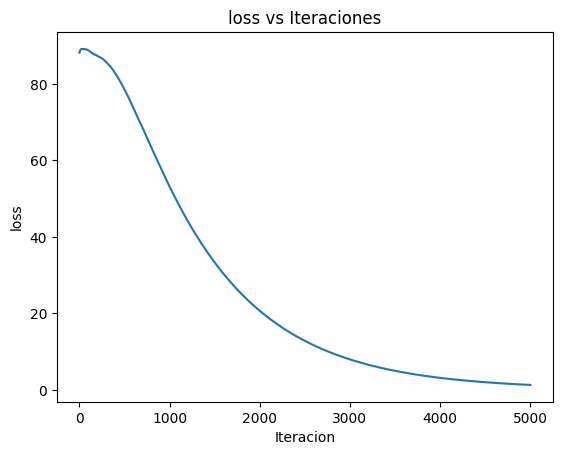

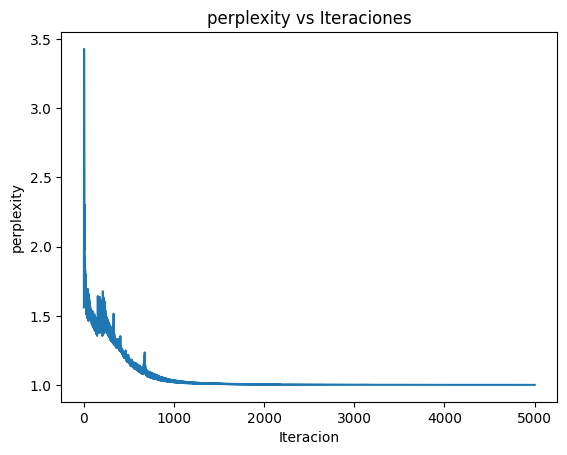

In [ ]:
# Test
with open('input.txt') as f:
    words = f.read()
chars = list(set(words))
words_size, vocab_size = len(words), len(chars)
char_to_int = {ch:i for i, ch in enumerate(chars)}
int_to_char = {i:ch for i, ch in enumerate(chars)}

rnn = vanillaRNN(n_x = vocab_size, n_h = 100, seq_length = 25, learning_rate = 1e-1)
loss_list, sample_char, perplexity_list = rnn.train(words, char_to_int, int_to_char, max_iter = 50000)


In [31]:
print(perplexity_list)

[np.float64(34.00165195999705), np.float64(35.76515107933722), np.float64(402.1595806118015), np.float64(2266.267217761087), np.float64(2829.399845976664), np.float64(6854.751732939969), np.float64(3282.779827336294), np.float64(23465.552923217754), np.float64(3948.2426909691203), np.float64(50220.835169598045), np.float64(1214.7504253421514), np.float64(5782.231434656505), np.float64(947.7626018593094), np.float64(105.49999714706766), np.float64(103.04415582971447), np.float64(477.71300798209865), np.float64(143.67620715679303), np.float64(52.04564882203787), np.float64(338.5367204693692), np.float64(200.36669880260945), np.float64(106.9831913502312), np.float64(104.10723504348381), np.float64(350.49189743238145), np.float64(360.21499342703447), np.float64(38.254955547622224), np.float64(103.76951864755236), np.float64(135.52753280804342), np.float64(63.03313687754598), np.float64(32.96431846953242), np.float64(141.6183740158861), np.float64(64.43445757896134), np.float64(19.191471497